# Overview of `eolearn.core`

`eolearn.core` is the main subpackage which implements basic building blocks (`EOPatch`, `EOTask` and `EOWorkflow`) and commonly used functionalities.

## EOPatch

EOPatch is common data-object that contains contains multi-temporal remotely sensed data of a single patch (area) of Earth’s surface typically defined by a bounding box in specific coordinate reference system.

There’s no limitation on the amount of data, or the type of data that can be stored. But typically, all of the information is internally stored in form of NumPy arrays as the following features:

- DATA with shape `t x n x m x d`: Time- and position-dependent remote sensing data (e.g. bands) of float type.
- MASK with shape `t x n x m x d`: Time- and position-dependent mask (e.g. ground truth, cloud/shadow mask, super pixel identifier) of integer or boolean type.
- SCALAR with shape `t x d`: Time-dependent and position-independent remote sensing data (e.g. weather data,) of float type.
- LABEL with shape `t x d`: Time-dependent and position-independent label (e.g. ground truth) of integer or boolean type.
- VECTOR: A collection of time-dependent geometry objects stored as a `geopandas.GeoDataFrame` with geometry and `TIMESTAMP` columns.
- DATA_TIMELESS with shape `n x m x d`: Time-independent and position-dependent remote sensing data (e.g. elevation model) of float type.
- MASK_TIMELESS with shape `n x m x d`: Time-independent and position-dependent mask (e.g. ground truth, region of interest mask) of integer or boolean type.
- SCALAR_TIMELESS with shape `d`:  Time-independent and position-independent remote sensing data of float type.
- LABEL_TIMELESS with shape `d`: Time-independent and position-independent label of integer or boolean type.
- VECTOR_TIMELESS: A collection of time-dependent geometry objects stored as a `geopandas.GeoDataFrame` with geometry column.
- META_INFO: A dictionary of additional metadata information (e.g. resolution, time difference).
- BBOX: A bounding box of the patch which is an instance of `sentinelhub.BBox`. It holds information about coordinates and CRS.
- TIMESTAMP: A list of dates of size `t` which are instances of `datetime.datetime` or `datetime.date`.

Note: `t` specifies time component, `n` and `m` are spatical components (number of rows and columns), and `d` is an additional component for data with multiple channels.

Create an empty patch

In [1]:
from eolearn.core import EOPatch

patch = EOPatch()

Set a feature to EOPatch. Each feature has to belong to one of the feature types listed above.

In [2]:
import numpy as np
import datetime as dt

from eolearn.core import FeatureType

new_bands = np.zeros((5, 10, 10, 13), dtype=np.float32)

patch[FeatureType.DATA]['bands'] = new_bands
# or patch.data['bands'] = new_bands

As the `FeatureType.DATA` represents temporal data, let's add some timestamps to the `EOPatch` as well:

In [3]:
patch.timestamp = [dt.date(2021,12,day) for day in range(1,6)]

Check current content of `EOPatch` with it's string representation.

In [4]:
patch

EOPatch(
  data: {
    bands: numpy.ndarray(shape=(5, 10, 10, 13), dtype=float32)
  }
  mask: {}
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {}
  label_timeless: {}
  vector_timeless: {}
  meta_info: {}
  bbox: None
  timestamp: [datetime.date(2021, 12, 1), ..., datetime.date(2021, 12, 5)], length=5
)

Get all non-empty features of EOPatch

In [5]:
patch.get_features()

{<FeatureType.DATA: 'data'>: {'bands'},
 <FeatureType.TIMESTAMP: 'timestamp'>: True}

Get a feature from EOPatch

In [6]:
data = patch[FeatureType.DATA]['bands']
# or patch.data['bands']

Save EOPatch to local folder. In case `EOPatch` would already exist in the specified location we are also giving a permission to overwrite its features.

In [7]:
from eolearn.core import OverwritePermission

patch.save('./example_patch', overwrite_permission=OverwritePermission.OVERWRITE_FEATURES)

Load EOPatch from the same folder

In [8]:
patch2 = EOPatch.load('./example_patch')

Compare EOPatches

In [9]:
patch == patch2

True

Remove a feature from EOPatch

In [10]:
del patch2[FeatureType.DATA]['bands']
# or del patch.data['bands']

Make a shallow and deep copy of EOPatch. Shallow copy will copy only a reference to data but not the data itself.

In [11]:
patch1 = patch.__copy__()
patch2 = patch.__deepcopy__()

patch.data['bands'] += 1

patch == patch1, patch == patch2

(True, False)

In [12]:
patch2[FeatureType.DATA]['bands2'] = new_bands

Merge two EOPatches: if the data for same timestamp is available in both, calculate `mean` 

In [13]:
merged = patch.merge(patch2, time_dependent_op='mean')

In [14]:
merged

EOPatch(
  data: {
    bands: numpy.ndarray(shape=(5, 10, 10, 13), dtype=float32)
    bands2: numpy.ndarray(shape=(5, 10, 10, 13), dtype=float32)
  }
  mask: {}
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {}
  label_timeless: {}
  vector_timeless: {}
  meta_info: {}
  bbox: None
  timestamp: [datetime.date(2021, 12, 1), ..., datetime.date(2021, 12, 5)], length=5
)

## EOTask

An EO task is any class the inherits from the abstract `EOTask` class. Each EO task has to implement the execute method; invoking __call__ on a EO task instance invokes the execute method. EO tasks are meant primarily to operate on EO patches (i.e. instances of EOPatch).

Add a feature using the EOTask

In [15]:
from eolearn.core import AddFeatureTask  # AddFeatureTask is a simple EOTask which adds a feature to a given EOPatch

patch = EOPatch()

feature = (FeatureType.DATA, 'bands')
add_feature = AddFeatureTask(feature)

data = np.zeros((5, 100, 100, 13))
patch = add_feature.execute(patch, data)
# or patch = add_feature(patch, data)

patch

EOPatch(
  data: {
    bands: numpy.ndarray(shape=(5, 100, 100, 13), dtype=float64)
  }
  mask: {}
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {}
  label_timeless: {}
  vector_timeless: {}
  meta_info: {}
  bbox: None
  timestamp: []
)

If a task doesn’t exist yet, the user can implement it and easily include it into his/hers workflow. There is very little or almost no overhead in the implementation of a new EOTask as seen from this minimal example

In [16]:
from eolearn.core import EOTask

class FooTask(EOTask):
    def __init__(self, foo_param):
        self.foo_param = foo_param

    def execute(self, eopatch, *, patch_specific_param=None):
        # do what foo does on input eopatch and return it
        return eopatch

EOTask’s arguments are either static (set when EOTask is initialized; i.e.e foo_param above) or dynamic (set during the execution of the workflow; i.e. patch_specific_param above).

The list of all EOTasks in the `eolearn.core` subpackage is available here https://eo-learn.readthedocs.io/en/latest/eotasks.html#core

## EOWorkflow

A workflow is a directed (acyclic) graph composed of instances of EOTask objects. Each task may take as input the results of other tasks and external arguments. The external arguments are passed anew each time the workflow is executed. The workflow builds the computational graph, performs dependency resolution, and executes the tasks. If the input graph is cyclic, the workflow raises a CyclicDependencyError.

The result of a workflow execution is an immutable mapping from tasks to results. The result contains tasks with zero out-degree (i.e. terminal tasks).

Add some tasks

In [17]:
from eolearn.core import CopyTask, RenameFeatureTask

copy_task = CopyTask()
rename_feature = RenameFeatureTask((FeatureType.DATA, 'bands', 'the_bands'))

Create a workflow

In [18]:
from eolearn.core import EOWorkflow

workflow = EOWorkflow([
    (add_feature, []),
    (copy_task, [add_feature]),
    (rename_feature, [copy_task])
])
                                    
result = workflow.execute({
    add_feature: {'eopatch': patch,
                  'data': new_bands}
})
                                    
result

WorkflowResults(outputs={}, start_time=datetime.datetime(2021, 12, 20, 16, 2, 37, 282875), end_time=datetime.datetime(2021, 12, 20, 16, 2, 37, 293566), stats={'AddFeatureTask-de88ec5c61a511ec82e7-af56a3bcfa0d': TaskStats(start_time=datetime.datetime(2021, 12, 20, 16, 2, 37, 292689), end_time=datetime.datetime(2021, 12, 20, 16, 2, 37, 292744)), 'CopyTask-de8acc6661a511ec8455-7b3329ba39bd': TaskStats(start_time=datetime.datetime(2021, 12, 20, 16, 2, 37, 293075), end_time=datetime.datetime(2021, 12, 20, 16, 2, 37, 293252)), 'RenameFeatureTask-de8ad85061a511ec8484-5aff0f7055ab': TaskStats(start_time=datetime.datetime(2021, 12, 20, 16, 2, 37, 293527), end_time=datetime.datetime(2021, 12, 20, 16, 2, 37, 293551))})

Display the dependency graph

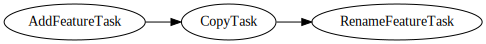

In [23]:
%matplotlib inline

workflow.dependency_graph('graph.png')

For a linear workflow such as previous one you can also use `LinearWorkflow` class

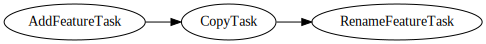

In [20]:
from eolearn.core import LinearWorkflow

workflow = LinearWorkflow(add_feature, copy_task, rename_feature)

result = workflow.execute({
    add_feature: {'eopatch': patch,
                  'data': new_bands}
})
                                    
workflow.dependency_graph('graph.png')

## EOExecutor

`EOExecutor` handles execution and monitoring of workflows. It enables executing a workflow multiple times and in parallel. It monitors execution times and handles any error that might occur in the process. At the end it generates a report which contains summary of the workflow and process of execution.

Execute previously defined workflow with different arguments

In [21]:
from eolearn.core import EOExecutor

execution_args = [  # EOWorkflow will be executed for each of these 3 dictionaries:
    {add_feature: {'eopatch': patch,
                  'data': new_bands}},
    {add_feature: {'eopatch': patch,
                  'data': new_bands - 1}},
    {add_feature: {'eopatch': patch,
                  'data': new_bands * 10}},
]

executor = EOExecutor(workflow, execution_args, save_logs=True, logs_folder='.')

executor.run(workers=3)  # The execution will use at most 3 parallel processes

  0%|          | 0/3 [00:00<?, ?it/s]

Make the report

In [22]:
%matplotlib

executor.make_report()

print('Report was saved to location: {}'.format(executor.get_report_filename()))

Using matplotlib backend: <object object at 0x129a07be0>
Report was saved to location: ./examples/core/eoexecution-report-2021_12_20-16_02_41/report.html
